# *PageRank* : de l'algorithme classique aux calculs distribués

Kim Antunez, Isabelle Bernard pour le projet d'*Elements Logiciels pour le Traitement de Données Massives* (2020-2021)


## Cadre d'analyse

*PageRank* est un algorithme, parmi d'autres, qui mesure la popularité d'une page web. Il fonctionne en classant les pages du Web en fonction de leur popularité (voir description détaillée dans les parties qui suivent).

Il a été inventé par Larry Page [1], cofondateur de Google, et est utilisé par le moteur de recherche de l'entreprise. Il s'agit d'une marque déposée dont le premier brevet a été déposé en 1997. Jusqu'en 2016, les internautes pouvaient obtenir une approximation du classement de chaque page mais, depuis, Google ne fournit plus cette valeur. 

###  Principe recherché par *PageRank*


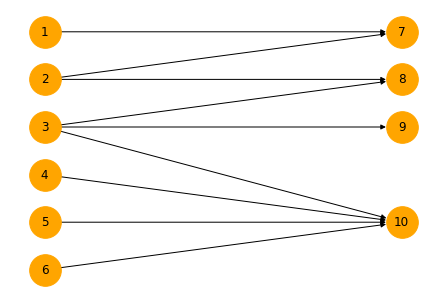

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_node(1,pos=(1,7))
G.add_node(2,pos=(1,6))
G.add_node(3,pos=(1,5))
G.add_node(4,pos=(1,4))
G.add_node(5,pos=(1,3))
G.add_node(6,pos=(1,2))
G.add_node(7,pos=(2,7))
G.add_node(8,pos=(2,6))
G.add_node(9,pos=(2,5))
G.add_node(10,pos=(2,3))
G.add_edges_from([(1, 7), (2, 7),(2, 8),(3, 8),(3, 9),
                  (3, 10),(4, 10),(5, 10),(6, 10)])
nx.draw(G, nx.get_node_attributes(G,'pos'), with_labels=True,
        node_size=1000, node_color = 'orange')
plt.show()

La modélisation adoptée utilise la théorie des graphes. Le web est un **graphe orienté** $G$ contient $N$ **noeuds** (pages, ici $N = 10$) reliés par des **liens** orientés (hyperliens). Un **degré entrant** (*in-degree*) d'une page correspond aux nombre d'hyperliens qui pointent sur elle et le **degré sortant** (*out-degree*) le nombre d'hyperliens vers lesquels elle pointe. 

Si l'on veut faire une première vulgarisation de l'algorithme, on peut dire que *PageRank* cherche à respecter les propriétés suivantes : 


1. **Popularité absolue** : plus le nombre de pages citant une page est grande, plus sa popularité doit être élevée. 

*Exemple : Dans la figure qui suit, le noeud $10$ est particulièrement populaire car 4 noeuds (les $3$, $4$, $5$ et $6$) pointent vers lui.*

2. **Popularité relative** : quand deux pages sont citées le même nombre de fois, c'est la page qui a été le plus cité en proportion par ses voisins qui doit être la plus populaire. 

*Exemple : On cherche à distinguer la popularité des noeuds $7$ et $8$ qui ont chacun deux noeuds qui pointent vers eux. On considère que le noeud $7$ est plus populaire car le noeud $1$ popularise exclusivement ce noeud, alors que le noeud $3$ popularise le noeud $8$ dans une moindre mesure car il popularise 2 autres noeuds ($9$ et $10$).* 

=> *PageRank* se rapproche d'une mesure de centralité sur le réseau du web. **Plus la page web a de chance d'être dans les premières positions lors d'une recherche sur internet, plus le *PageRank* sera élevé**. Son principe est d'attribuer à chaque page un score proportionnel au nombre de fois que passerait par cette page un utilisateur parcourant le graphe du Web en cliquant aléatoirement, sur un des liens apparaissant sur chaque page. Une page a un *PageRank* d'autant plus important qu'est grande la somme des *PageRanks* des pages qui pointent vers elle. 


### Algorithme de *PageRank* 

La valeur  (ou rang) *PageRank* d'une page $p$ ($r(p)$) dépend des valeurs *PageRank* de chacune des pages $q$ qui pointent vers la page $p$ ($q \rightarrow p$) divisées par le nombre de noeuds auxquels fait référence la page $q$ ($d(q)$ = degré sortant) : 

\begin{equation}
r(p)=\sum_{ q \rightarrow p}\frac{r(q)}{d(q)}
\end{equation}

L'équation 1 peut être réécrite sous forme matricielle $\vec{r} = L \vec{r}$ où le vecteur $\vec{r}$ est le vecteurs des valeurs PageRank des $N$ pages et la matrice $L$ est telle que $L[q, p] = \frac{1}{d(q)}$ s'il y a un lien qui relit le noeud $q$ au noeud $p$ et qui vaut 0 sinon.  

Le programme peut être résolu par l’algorithme de la puissance itérée (*power iteration method*) qui repose sur le théorème de Perron-Frobenius et est dédié à la recherche de valeurs et vecteurs propres. Cet algorithme est utilisé dans le cas de PageRank en raison de la grande taille de la matrice qui encourage à utiliser la matrice au travers de produits, mais sa vitesse de convergence (convergence qui d'ailleurs n'est pas garantie) est assez lente. On stoppe donc l'algorithme après un certain nombre d'itérations ou si la norme $L^1$ de l'écart des valeurs *PageRank* entre 2 itérations est inférieure à un certain seuil de tolérance qui dépend de $N$. 

### Approximation locale de *PageRank* 

La très grande taille de ce graphe et son évolution rendent coûteuses en opérations le calcul d'un *PageRank* pour une nouvelle page. C'est pourquoi des **algorithmes d'approximation** existent.

L'approximation locale de l'algorithme *PageRank* que nous utilisons s'appuie sur l'article [3]. 

Il s'agit d'approximer le vecteur des rangs de l'ensemble des pages en faisant un calcul itératif (marche aléatoire). Après avoir initialisé un rang de $\frac{1}{N}$ pour toutes les pages, on met à jour le vecteur de rangs de la manière suivante où $i$ correspond au numéro de l'itération : 

\begin{equation}
r^{i+1}(p)=\sum_{ q \rightarrow p}\frac{r^{i}(q)}{d(q)}
\end{equation}

Cependant, dans cette formulation, si un noeud $p$ n'a pas de degré sortant $q$, c'est-à-dire qu'il ne fait référence à aucune page (*dangling node*), son rang n'est pas mis à jour dans l'algorithme à l'itération suivante, ce qui entraîne une perte de la valeur totale du *PageRank*. Une solution serait de nettoyer itérativement le graphe en enlevant les pages sans hyperliens. Mais, même en procédant ainsi, le graphe peut toujours contenir des groupes de pages très peu connectés entre eux qui posent le même problème. C'est pourquoi on introduit un facteur d'amortissement $\alpha$ (par exemple $\alpha = 0,85$, *teleportation factor*). Tout marche comme si on réalise l'algorithme précédent (c'est-à-dire on choisit aléatoirement un degré sortant du noeud considéré) avec une probabilité $\alpha$ et on choisit un noeud au hasard avec la probabilité $1-\alpha$ (*damping factor*) : 

\begin{equation}
r^{i+1}(p)=\frac{1-\alpha}{N}+\alpha \sum_{ q \rightarrow p}\frac{r^{i}(q)}{d(q)}
\end{equation}

Le paramètre $\alpha$ est fixé par le *data-scientist*. Ainsi, l'algorithme tel que nous l'avons décrit (y compris son initialisation) est **déterministe** : on obtient toujours le même résultat à nombre d'itération et $\alpha$ fixés.  

### Approximation locale de *PageRank*  avec l'approche MapReduce avec Spark

Comme évoqué en cours d’ELTDM, **MapReduce**, inventé également par Google, permet d’effectuer des calculs parallèles, et souvent distribués, de données potentiellement très volumineuses, en les distribuant dans un cluster de machines.

Nous avons vu que l’algorithme *PageRank* est récursif, itératif, et dépend d’une structure de millions d’hyperliens. Le fait de l’implémenter sur une unique machine dont la mémoire doit disposer de l’ensemble du graphe le rend difficilement « scalable ». C’est pourquoi l’utilisation d’une structure en map-reduce se justifie largement ici. 

**Spark** est un framework open source qui permet de faire le calcul distribué dont nous avons besoin. Il réalise une lecture des données au niveau du cluster (grappe de serveurs sur un réseau), effectue toutes les opérations d'analyse nécessaires, puis écrit les résultats à ce même niveau. 

Spark ne manipule pas des données classiques mais des **R**esilient **D**istributed **D**ataset ou **RDD**, une collection de données calculée et conservée en mémoire vive. Ce sont des lignes de données, non modifiables (toute modification implique la création d'un nouveau RDD), qui ne peuvent pas être cassées (il faut parcourir le fichier en entier, il n'y a pas d'index) et qui sont distribuées dans un ordre imprévisible dans les différents clusters.  

Grâce à la librairie python `pyspark` nous avons pu nous initier à cette technologie en l'utilisant sur nos PC **en local**. 


#### Version simplifiée

Nous l'avons vu, l’idée générale de *PageRank* est de **répandre** les masses de probabilités au fil de chaque flux d’**hyperliens sortants**. A la fin de chaque itération, chaque nœud est résumé par une valeur *PageRank* qui résume les fois où l’utilisateur navigant au hasard passe par la page (voir la figure 1 qui résume différentes itérations de l’algorithme dans le cas simplificateur où $\alpha = 1$). 

![Figure1](img/img1.png)

**Figure 1** : Schéma de l'algorithme *PageRank*

*Source : Lin, Dyer 2010*

L’implémentation MapReduce de PageRank est telle que chaque itération se décompose en 2 phases (cf. figure 2) : 
1. la phase « Map » : on sépare chaque nœud (page) associé à ses hyperliens
2. la phase « Reduce » : les contributions sont sommées pour tous les nœuds de destination

![Figure2](img/img2.png)

**Figure 2** : Schéma de l'algorithme *PageRank* avec l'approche MapReduce

*Source : Lin, Dyer 2010*

Cela se traduit algorithmiquement par le pseudo-code suivant : 

        classMapper
            method Map(nid n,node N)
            p← N.PageRank/|N.AdjacencyList|
            Emit(nidn,N) #Pass along graph structure
            for all nodeid m∈N. AdjacencyList do 
                Emit(nidm,p) #Pass PageRank mass to neighbors

        classReducer
            method Reduce(nid m,[p1,p2,...])
            M←∅
            for all p∈counts [p1,p2,...] do 
                if IsNode(p) then 
                    M←p #Recover graph structure
                else
                    s←s+p #Sum incoming PageRank contributions
            M.PageRank←s
            Emit(nid m,node M)
    
*Source : Lin, Dyer 2010*

#### Introduction du facteur $\alpha$

La modélisation se complique légèrement quand on considère le facteur $\alpha$, on fait intervenir alors deux termes dans la somme de l'étape *reduce*, comme modélisé dans l'équation 3. 

La modélisation se complique encore davantage en présence de *dangling* nodes. En plus d'ajouter le facteur $\alpha$, il s'agit également de redistribuer (faire un nouveau mapping sur tous les nœuds) la masse perdue à l’ensemble des nœuds du graphe de manière égale. 

**=> Ici, nous simplifions légèrement le processus en supprimant les quelques *dangling nodes* présents dans les données et nous nous concentrons sur l'implémentation des 3 méthodes évoquées plus haut :** 

**1. L'algorithme de *PageRank* global (`pagerank_global`)**

**2. Son approximation locale telle que décrite dans l'article [3] (`pagerank_local`)**

**3. La version parallélisée de l'approximation locale en utilisant les calculs distribués grâce à Spark (`pagerank_local_spark`)**


<!-- 3 options sont possibles : 

1.	passer par un compteur
2.	quand le *mapper*  rencontre un *dangling node*, sa valeur PageRank est émise par une clef spéciale et le *reducer* doit être modifié en conséquence. 
3.	condidérer la masse perdue comme des données « à part » et utiliser les méthodes d’aggregation *in-mapper*

Finalement, une itération de *PageRank* fait intervenir 2 processus MapReduce : 

1. Distribuer la masse PageRank tout au long des hyperliens sortants
2. Faire attention aux *dangling nodes* et introduire alors le paramètre alpha
-->

<!--Comme précédemment, on procède à des itérations jusqu’à obtenir convergence (modifications des *PageRank* faible entre 2 itérations. C’est pourquoi le *PageRank driver program* doit vérifier cette condition à la fin de chaque itération. -->

## Application


La base de données utilisée provient de la [librairie SNAP](http://snap.stanford.edu/data/index.html) de l'université de Stanford. Les données qui y sont mises à disposition l'ont été dans la plupart du temps dans des objectifs de recherche. 

Il s'agit du fichier `web-Google`, mis à disposition par Google en 2002 lors d'un concours de programmeurs, dont les 875 713 noeuds représentent des pages webs et les 5 105 039 liens orientés représentent les hyperliens. 

In [2]:
from pyspark import SparkContext, SparkConf
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
from timeit import default_timer
%matplotlib inline
#%matplotlib notebook
from operator import add

### Fonctions utiles

Divers

In [3]:
# Charger les données de réseaux, sélectionner le nombre de lignes à garder
# et enregistrer le fichier. 
def sauver_donnees(nb_lignes=60, fichier="web-Google"):
    dfFile = pd.read_csv("data/{}.txt".format(fichier), sep='\t',
                             header=3, nrows = nb_lignes)
    nodesList = dfFile['# FromNodeId'].unique()
    #enlever les donnees inutiles
    dfFile = dfFile[dfFile['ToNodeId'].isin(nodesList)] 
    dfFile.to_csv("data/{}{}.txt".format(fichier, nb_lignes), sep=' ',
                  header=False, index=False)
    
# Afficher les résultats de l'algorithme PageRank à l'utilisateur
def afficher_resultats_PR(resultat):
    duration = resultat[0]
    ranks = resultat[1]
    for key in ranks: # 3 chiffres significatifs
        ranks[key] = round(ranks[key], 3) 
    print(f'Le temps de calcul est de {round(duration,4)} secondes')
    print(f'La liste des noeuds et de leurs valeurs PageRank finales est')
    print(ranks)
    print('\n')

Les différents algorithmes de PageRank (global, local non distribué et distribué)

In [4]:
def pagerank_global(G, alpha=1, max_iter=100, tol=10000000000000000): 
  
    """Retourne : un dictionnaire de noeuds dont les valeurs correspondent
     aux PageRank ainsi que le temps de calcul de l'algorithme
      
    Paramètres
    ---------- 
    -G : graph (de type NetworkX) 
    -alpha : paramètre d'amortissement (1 par défaut) 
    -max_iter : nombre maximum d'itération dans la recherche de valeurs propres. 
    -tol : erreur de tolérence acceptée pour la convergence
    de la méthode de recherche des valeurs propres. 
     
    """
    
    start = default_timer()
    
    # Créer une copie sous forme de graphique droit-stochastique (pour chaque noeud, 
    # la somme des poids des liens sortant vaut 1)    
    W = nx.stochastic_graph(G, weight=None)
    N = W.number_of_nodes() 
  
    # Initialisation à 1/N 
    x = dict.fromkeys(W, 1.0 / N) 
    p = dict.fromkeys(W, 1.0 / N)
    dangling_weights = x 
    dangling_nodes = [n for n in W if W.out_degree(n, weight=None) == 0.0] 
    
    #algorithme de la puissance itérée
    for _ in range(max_iter): 
        xlast = x 
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes) 
        for n in x: 
  
            # multiplication à gauche x^T=xlast^T*W 
            for nbr in W[n]: 
                x[nbr] += alpha * xlast[n] * W[n][nbr][None] 
            x[n] += danglesum * dangling_weights[n] + (1-alpha) * p[n] 
          
        # vérifier la convergence L1
        err = sum([abs(x[n] - xlast[n]) for n in x]) 
        if err < N*tol:
            duration = default_timer() - start
            retour = (duration, x)
            return retour
    raise NetworkXError('pagerank: erreur de convergence au bout '
                        'de %d iterations.' % max_iter) 

In [97]:
def pagerank_local(G, alpha=1, max_iter=10,
                   only_timer=False, timer_mapreduce=True):  

    """Retourne : un dictionnaire de noeuds dont les valeurs correspondent
     aux PageRank ainsi que le temps de calcul de l'algorithme
      
    Paramètres
    ---------- 
    -G : graph (de type NetworkX) 
    -alpha : paramètre d'amortissement (1 par défaut) 
    -max_iter : nombre maximum d'itération dans la recherche de valeurs propres. 
    - only_timer : si vaut True, ne retourne que le temps de calcul, sinon retourne 
    aussi la valeur des rangs à la dernière itération 
    - timer_mapreduce : si vaut True, le timer calcul l'efficacité de calcul qui peut
    être distribuée (map-reduce). si vaut False, le timer calcul le temps
    d'initialisation
    
    """
    
    ### Initialisation
    if not timer_mapreduce:
            start = default_timer()
    # Successors and Predecessors
    successors = {node: list(G.successors(node)) for node in list(G.nodes())} 
    predecessors = {node: list(G.predecessors(node)) for node in list(G.nodes())}
    # Calcul du nombre total de noeuds (pages)
    N = G.number_of_nodes() 
    # Initialisation chacun des rangs à 1/N
    ranks = {node: 1.0/N for node in list(G.nodes())} 
    if not timer_mapreduce:
            duration = default_timer() - start
    
    # Lancer le chronomètre pour comparer partie non distribuée 
    # avec la partie distribuée
    if timer_mapreduce:
            start = default_timer()
    
    for i in range(max_iter):
        r_sur_d = {node :(float(1.0/N) if len(successors[node])==0
          else float(ranks[node]/len(successors[node]))) for node in list(G.nodes())}
        ranks_new = {
            node: (1-alpha)/N +
            alpha * sum([r_sur_d[key] for key in predecessors[node]])
            for node in list(G.nodes())
        }
        #print(sum(ranks_new.values()))
        ranks = ranks_new
    if timer_mapreduce:
            duration = default_timer() - start
    if only_timer:
        retour=duration
    else:
        retour=(duration, ranks)
    return retour

In [6]:
# Récupère un noeud entrant et son noeud sortant et les met dans une liste. 
def ligne_vers_node(ligne):
    nodes = ligne.split(' ') 
    return int(nodes[0]), int(nodes[1])

def pagerank_local_spark(RddDataBase,alpha=1, max_iter=10,
                         only_timer=False,timer_mapreduce=True): 

    """Retourne : un dictionnaire de noeuds dont les valeurs correspondent
     aux PageRank ainsi que le temps de calcul de l'algorithme
      
    Paramètres
    ---------- 
    -RddDataBase : graph (de type RDD) 
    -alpha : paramètre d'amortissement (1 par défaut) 
    -max_iter : nombre maximum d'itération dans la recherche de valeurs propres. 
    - only_timer : si vaut True, ne retourne que le temps de calcul, sinon retourne 
    aussi la valeur des rangs à la dernière itération 
    - timer_mapreduce : si vaut True, le timer calcul l'efficacité de calcul qui peut
    être distribuée (map-reduce). si vaut False, le timer calcul le temps
    d'initialisation
    
    """

    
    ### Initialisation
    if not timer_mapreduce:
            start = default_timer()
    # Créer l'association des paires clef/valeur
    # Clef : noeud. valeur : noeuds vers lesquels ils pointent (outlinks)
    # distinct : on cherche la liste unique des noeuds.
    # groupByKey : on groupe par noeud et on regarde les noeuds sortants
    links = RddDataBase.map(lambda ligne: ligne_vers_node(ligne))\
    .distinct().groupByKey().cache()
    # Calcul du nombre total de noeuds (pages)
    N = links.count() #Ne compte pas les dangling nodes !
    # Initialisation chacun des rangs à 1/N
    ranks = links.map(lambda node: (node[0],1.0/N))
    
    if not timer_mapreduce:
            duration = default_timer() - start
    
    # Lancer le chronomètre pour la partie distribuée
    if timer_mapreduce:
            start = default_timer()
            
    ## MapReduce = mise à jour itérative des rangs
    ### étape répétée jusqu'à ce que le nombre d'itérations soit atteint. 
    for i in range(max_iter):
    # MAP = floatMap : Calculer pour chaque noeud p les ratios Rq/Dq 
    #(float(x[1][1])/len(x[1][0])) des noeuds q sortants de p.
        new_ranks = links.join(ranks)\
                    .flatMap(lambda x : [(i, float(x[1][1])/len(x[1][0]))\
                                         for i in x[1][0]])  
        #print(new_ranks.sortByKey().collect())
        # REDUCE = reduceByKey : Pour chaque noeud p, sommer les valeurs associées 
        # aux noeuds entrants et mettre à jour les rangs.
        #ranks = ranks.reduceByKey(lambda x,y: x+y) #without alpha
        new_ranks = new_ranks.reduceByKey(add).mapValues(
            lambda rank: rank * alpha + (1-alpha)/N)  
        #print(sum({row[0]: row[1]  for row in new_ranks.collect()}.values()))
        ranks=new_ranks
        
    ### Temps de calcul
    if timer_mapreduce:
            duration = default_timer() - start
    if only_timer:
        retour=duration
    else:
        retour=(duration, {row[0]: row[1]  for row in ranks.sortByKey().collect()}) 
    return retour

Graphiques

In [7]:
# Temps de calcul en fonction de la taille du graphe
def creer_donnees_graphique_timer_lignes(nbs_lignes,nb_iter,fichier="web-Google",
                                         timer_mapreduce=True):
    without_spark_list=[]
    with_spark_list=[]
    for nb_lignes in nbs_lignes: 
        df = pd.read_csv("data/{}{}.txt".format(fichier,nb_lignes),
                     sep=' ', names=["in","out"])
        G=nx.from_pandas_edgelist(df, 'in', 'out',create_using=nx.DiGraph())
        RddDataBase = sc.textFile("data/{}{}.txt".format(fichier,nb_lignes))
        without_spark = pagerank_local(G,max_iter=nb_iter,
                                            alpha=0.85, only_timer=True,
                                       timer_mapreduce=timer_mapreduce)
        without_spark_list.append(without_spark)
        with_spark = pagerank_local_spark(RddDataBase,max_iter=nb_iter,
                                               alpha=0.85, only_timer=True,
                                       timer_mapreduce=timer_mapreduce)
        with_spark_list.append(with_spark)
    return(with_spark_list,without_spark_list)

def creer_graphique_timer_lignes(nbs_lignes,with_spark_list,
                                 without_spark_list,nb_iter,
                                echelle_log=True,timer_mapreduce=True):    
    ax = plt.subplot()
    plt.scatter(nbs_lignes,with_spark_list,marker='o')
    plt.plot(nbs_lignes,with_spark_list , label="Avec Spark")
    plt.scatter(nbs_lignes,without_spark_list,marker='o')
    plt.plot(nbs_lignes,without_spark_list , label="Sans Spark")
    leg = plt.legend()
    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if timer_mapreduce:
        plt.title("Temps d'exécution de l'algorithme ({} itérations)\
        en fonction de la taille du fichier".format(nb_iter))
        plt.ylabel("Temps d'exécution (secondes)")
    else:
        plt.title("Temps d'initialisation de l'algorithme ({} itérations)\
                  en fonction de la taille du fichier".format(nb_iter))
        plt.ylabel("Temps d'initialisation (secondes)")
    if echelle_log:
        plt.xscale("log")
        plt.xlabel('Taille du fichier (échelle log)')
    else:
        plt.xlabel('Taille du fichier')
    #plt.savefig('Output/name.png')
    plt.show()

In [8]:
# Temps de calcul en fonction du nombre d'itérations
def creer_donnees_graphique_timer_iters(nbs_iters,nb_lignes,fichier="web-Google",
                                         timer_mapreduce=True):
    without_spark_list=[]
    with_spark_list=[]
    for nb_iters in nbs_iters: 
        df = pd.read_csv("data/{}{}.txt".format(fichier,nb_lignes),
                     sep=' ', names=["in","out"])
        G=nx.from_pandas_edgelist(df, 'in', 'out',create_using=nx.DiGraph())
        RddDataBase = sc.textFile("data/{}{}.txt".format(fichier,nb_lignes))
        without_spark = pagerank_local(G,max_iter=nb_iters,
                                            alpha=0.85, only_timer=True,
                                         timer_mapreduce=timer_mapreduce)
        without_spark_list.append(without_spark)
        with_spark = pagerank_local_spark(RddDataBase,max_iter=nb_iters,
                                               alpha=0.85, only_timer=True,
                                         timer_mapreduce=timer_mapreduce)
        with_spark_list.append(with_spark)
    return(with_spark_list,without_spark_list)

def creer_graphique_timer_iters(nbs_iters,with_spark_list,
                                without_spark_list,nb_lignes,
                                echelle_log=True,timer_mapreduce=True):    
    ax = plt.subplot()
    plt.scatter(nbs_iters,with_spark_list,marker='o')
    plt.plot(nbs_iters,with_spark_list , label="Avec Spark")
    plt.scatter(nbs_iters,without_spark_list,marker='o')
    plt.plot(nbs_iters,without_spark_list , label="Sans Spark")
    leg = plt.legend()
    leg = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    #leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    #leg.get_frame().set_alpha(0.5)
    if timer_mapreduce:
        plt.title("Temps d'exécution de l'algorithme en fonction\
                  du nombre d'itérations")
        plt.ylabel("Temps d'exécution (secondes)")
    else:
        plt.title("Temps d'initialisation de l'algorithme en fonction\
        du nombre d'itérations")
        plt.ylabel("Temps d'initialisation (secondes)")
        
    if echelle_log:
        plt.xscale("log")
        plt.xlabel("Nombre d'itérations (échelle log)")
    else:
        plt.xlabel("Nombre d'itérations")
    
    plt.show()

### Exemple illustratif sur un graphe de petite taille

Nous présentons tout d'abord quelques résultats (valeurs PageRank finales et temps de calcul) des trois algorithmes implémentés sur un petit extrait du jeu de données et seulement deux itérations. Cette partie a une visée principalement pédagogique.  


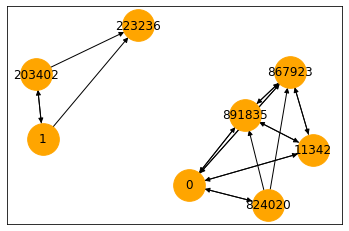

In [95]:
#sauver_donnees(nb_lignes=100, fichier="web-Google") 

#Représentation graphique des noeuds (pages) et des liens entre ces noeuds (pages)
fichier = "web-Google"
nb_lignes = 100
df1 = pd.read_csv("data/{}{}.txt".format(fichier,nb_lignes),
                  sep=' ', names=["in","out"])
G1=nx.from_pandas_edgelist(df1, 'in', 'out',create_using=nx.DiGraph())
#agrandir l'espacement par défaut entre noeuds
pos = nx.spring_layout(G1, k=0.9, iterations=20)
nx.draw_networkx(G1, node_color = 'orange', 
                 node_size = 1000,arrows=True, pos=pos)
plt.savefig('graph/graph_nodes_test.png')

Remarque : Dans cet exemple il y a un *dangling node* (223236). Un *dandling node* $q$ n'a de lien sortant vers aucun individu, et son ratio $\frac{r^{i}(q)}{d(q)}$ vaut l'infini puisque $d(q)=0$. Dans ce cas, on doit normalement fixer le ratio à $0$ et rééquilibrer le poids des autres noeuds pour que la somme des rangs soit toujours égale à 1. Ici, pour simplifier les calculs et améliorer la vitesse de l'algorithme, nous retirons ce noeud. 

In [10]:
dangling_nodes = [n for n in G1 if G1.out_degree(n, weight=None) == 0.0] 
print(dangling_nodes)
G1.remove_nodes_from(dangling_nodes) #car méthode ne gère pas dandling nodes

[223236]


In [11]:
# Connexion au cluster / test en local
spark_conf = SparkConf()\
    .setAppName('Page Rank With PySpark')\
    .setMaster('local')
#sc.stop()
sc = SparkContext(conf=spark_conf)

#Partitionner les données pour Spark
RddDataBase1 = sc.textFile("data/{}{}.txt".format(fichier,nb_lignes))

**PageRank global**

In [59]:
print("Algorithme global en 2 itérations\n")
print("Pour alpha=1 : ")
afficher_resultats_PR(pagerank_global(G1, alpha=1, max_iter=2))
print("Pour alpha=0.85 :")
afficher_resultats_PR(pagerank_global(G1, alpha=0.85, max_iter=2)) 

Algorithme global en 2 itérations

Pour alpha=1 : 
Le temps de calcul est de 0.0004 secondes
La liste des noeuds et de leurs valeurs PageRank finales est
{0: 0.19, 11342: 0.131, 824020: 0.036, 867923: 0.179, 891835: 0.179, 1: 0.143, 203402: 0.143}


Pour alpha=0.85 :
Le temps de calcul est de 0.0002 secondes
La liste des noeuds et de leurs valeurs PageRank finales est
{0: 0.183, 11342: 0.133, 824020: 0.052, 867923: 0.173, 891835: 0.173, 1: 0.143, 203402: 0.143}




L'algorithme global est ici très rapide à tourner en raison de la petite taille du graphe. Ce ne serait pas le cas pour un très gros graphe. 

On remarque que le noeud 0 est celui qui présente le meilleur rang *PageRank* (de nombreuses pages y font référence), suivi de près par les noeuds 867923 et 891835. En revanche, le noeud 824020 a un très mauvais score, ce qui s'explique facilement par le fait que seul le noeud 0 possède un hyperlien qui pointe vers lui. 

**PageRank local non distribué**

In [60]:
print("Algorithme local en 2 itérations\n")
print("Pour alpha=1 : ")
afficher_resultats_PR(pagerank_local(G1, alpha=1, max_iter=2))
print("Pour alpha=0.85 :")
afficher_resultats_PR(pagerank_local(G1, alpha=0.85, max_iter=2)) 

Algorithme local en 2 itérations

Pour alpha=1 : 
Le temps de calcul est de 0.0004 secondes
La liste des noeuds et de leurs valeurs PageRank finales est
{0: 0.175, 11342: 0.167, 824020: 0.048, 867923: 0.163, 891835: 0.163, 1: 0.143, 203402: 0.143}


Pour alpha=0.85 :
Le temps de calcul est de 0.0001 secondes
La liste des noeuds et de leurs valeurs PageRank finales est
{0: 0.172, 11342: 0.159, 824020: 0.06, 867923: 0.162, 891835: 0.162, 1: 0.143, 203402: 0.143}




L'approximation locale de *PageRank* est encore plus rapide à tourner que la résolution globale de l'algorithme. 

Bien que les résultats soient différents (c'est normal, l'algorithme l'est aussi !). Les résultats vont dans le même sens que l'implémentation précédente. Le noeud 0 présente toujours le meilleur *PageRank* et le noeud 824020 toujours le moins bon. 

**PageRank local distribué**

In [62]:
print("Algorithme local en 2 itérations\n")
print("Pour alpha=1 : ")
afficher_resultats_PR(pagerank_local_spark(RddDataBase1, alpha=1, max_iter=2))
print("Pour alpha=0.85 :")
afficher_resultats_PR(pagerank_local_spark(RddDataBase1, alpha=0.85, max_iter=2)) 

Algorithme local en 2 itérations

Pour alpha=1 : 
Le temps de calcul est de 0.2582 secondes
La liste des noeuds et de leurs valeurs PageRank finales est
{0: 0.175, 1: 0.036, 11342: 0.167, 203402: 0.036, 223236: 0.071, 824020: 0.048, 867923: 0.163, 891835: 0.163}


Pour alpha=0.85 :
Le temps de calcul est de 0.1922 secondes
La liste des noeuds et de leurs valeurs PageRank finales est
{0: 0.172, 1: 0.056, 11342: 0.159, 203402: 0.056, 223236: 0.091, 824020: 0.06, 867923: 0.162, 891835: 0.162}




Enfin, les résultats de l'algorithme précédent implémenté en utilisant des calculs distribués (*framework* Spark) présente les mêmes résultats (l'algorithme est identique et est simplement parallélisé). 

Il met beaucoup plus de temps que l'algorithme non distribué à tourner, mais il ne faut pas s'arrêter sur ce résultat. En effet, ici la taille du graphe est très petite. La partie suivante va montrer que pour des graphes plus grands et un nombre d'itérations plus important, l'efficacité de l'algorithme parallélisé va s'avérer bien meilleure que celle de l'algorithme initial. 

### Graphiques de mesure de performance

Cette dernière partie vise à illustrer l'efficacité du calcul distribué avec Spark par rapport à la version de l'algorithme sans calcul distribué. 

In [63]:
spark_conf = SparkConf()\
    .setAppName('Page Rank With PySpark')\
    .setMaster('local')
sc.stop()
sc = SparkContext(conf=spark_conf)

#### Temps de calcul en fonction de la taille du graphe (à nombre d'itérations fixé)

Conformément aux intuitions, plus la taille du graphe augmente, plus Spark présente des avantages en termes de temps de calcul. En effet, quand la taille du fichier est très petite, le calcul distribué opéré par Spark ne présente pas d'avantage voire détériore le temps de calcul par rapport à la version non distribuée. En revanche, on remarque qu'à partir d'une certaine taille de graphe, l'efficacité de Spark devient explosive, si bien que nous avons choisi de représenter l'axe des abscisse sous forme logarithmique. 

Nous observons la même conclusion, pour 5 et 20 itérations (avec bien sûr, des niveaux de temps de calcul, en ordonnée, différents). C'est pourquoi nous regardons d'un peu plus près l'évolution du temps de calcul en fonction du nombre d'itérations dans la partie suivante. 

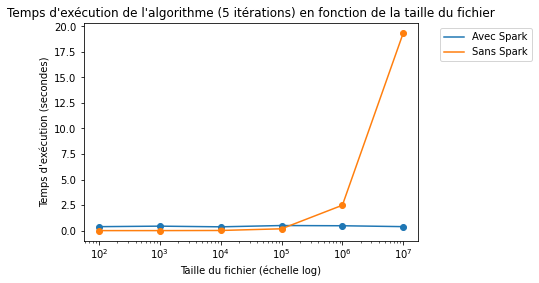

In [78]:
nbs_lignes=[100,1000,10000,100000,1000000,10000000]
with_spark_list, without_spark_list = creer_donnees_graphique_timer_lignes(
    nbs_lignes,
    nb_iter=5)
creer_graphique_timer_lignes(nbs_lignes,with_spark_list,without_spark_list,nb_iter=5)

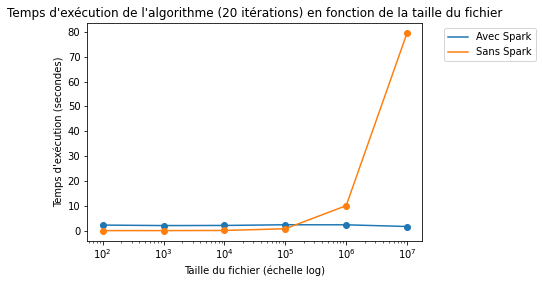

In [79]:
nbs_lignes=[100,1000,10000,100000,1000000,10000000]
with_spark_list, without_spark_list = creer_donnees_graphique_timer_lignes(
    nbs_lignes,
    nb_iter=20)
creer_graphique_timer_lignes(nbs_lignes,with_spark_list,
                             without_spark_list,nb_iter=20)

#### Temps de calcul en fonction du nombre d'itérations (à taille de graphe fixée)

En plus d'être de plus en plus efficace au fur et à mesure que la taille des graphes augmente, Spark est également de plus en plus efficace au fur et à mesure que le nombre d'itérations augmente. 

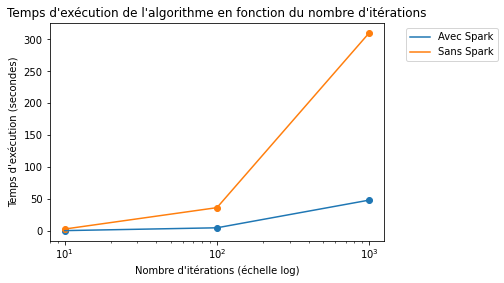

In [97]:
nbs_iters=[10,100,1000]
with_spark_list, without_spark_list = creer_donnees_graphique_timer_iters(
    nbs_iters,nb_lignes=1000000)
creer_graphique_timer_iters(nbs_iters,with_spark_list,
                            without_spark_list,nb_lignes=1000000)

**Pour conclure**, la distribution des calculs de l'algorithme *PageRank* fait gagner un temps considérable à partir d'une certaine taille de graphe et quand le nombre d'itérations de l'algorithme est suffisamment important. 

### Ouvertures

#### Spark, un outil pas totalement magique 

Ce travail a montré que Spark est une méthode assez intuitive et visiblement particulièrement efficace pour distribuer l'algorithme de *PageRank* (boucle d'étapes Map-Reduce) sur des graphes de grandes tailles (*Big Data*). 

Toutefois, il existe des cas où l'usage de Spark peut devenir inefficace. En effet, comme son fonctionnement est très sophistiqué, cela amène à des tâches d'initialisation chronophages. C'est pourquoi il est en pratique important de monitorer la durée d'initialisation et de la comparer avec la durée computationnelle. 

On le voit d'ailleurs sur nos données, la durée d'initialisation de l'algorithme *PageRank* est sensiblement plus importante dans la version distribuée utilisant Spark. Cet écart d'initialisation est d'autant plus grand que la taille du graphe est grande.

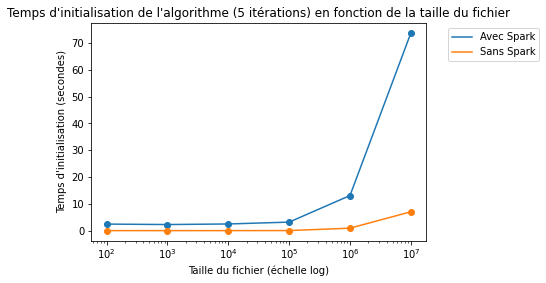

In [114]:
nbs_lignes=[100,1000,10000,100000,1000000,10000000]
with_spark_list, without_spark_list = creer_donnees_graphique_timer_lignes(
    nbs_lignes,nb_iter=5, timer_mapreduce=False)
creer_graphique_timer_lignes(nbs_lignes,with_spark_list,
                             without_spark_list,nb_iter=5,timer_mapreduce=False)

#### Spark en Cluster

Nous avions utilisé jusqu'à présent l'installation de Spark en local.  Dans ce mode de déploiement, Spark exécute tout dans une unique machine virtuelle Java (JVM). 

<!-- La parallélisation par défaut est le nombre de threads tel que spécifié dans l'URL principale.-->

Cette installation n'est pas strictement identique à celle dans un cluster réel. Dans un "vrai" cluster, il faut penser à uploader les données et ne pas les conserver uniquement en local. Il faut également installer sur chaque machine du cluster les dépendances du script, dès la création du cluster ou avant de lancer un script pour les installations plus spécifiques. Il est aussi plus complexe de débugger le code (par exemple, la fonction `print` peut ne pas fonctionner sur les clusters).

Pour nous initier à l'utilisation de cluster, nous avons créé un environnement dans lequel nous avons créé une machine maître (*master*) et plusieurs machines secondaires (*workers*). Pour cela, nous avons utilisé les commandes suivantes dans notre terminal windows. 

    # Attention code à exécuter en mode administrateur !
    # Créer un noeud maître
    cd "C:/Users/Spark/spark-3.0.1-bin-hadoop2.7/bin"
    spark-class org.apache.spark.deploy.master.Master
    # Créer autant de noeuds "workers" que souhaité (répéter la commande qui suit)
    cd "C:/Users/Spark/spark-3.0.1-bin-hadoop2.7/bin"
    spark-class org.apache.spark.deploy.worker.Worker spark://192.168.1.10:7077

Suite à ces instructions, nous pouvons consulter à l'adresse http://192.168.1.10:8080/ les différents noeuds souhaités. La figure 3 montre un exemple avec 1 *master* et 2 *workers*. 
    
![Figure1](img/spark.png)

**Figure 3** : Un aperçu de Spark

Nous avons ensuite évalué le temps de calcul de l'algorithme *PageRank* (`nb_lignes` = 10000, `alpha`= 0,85 et `max_iter` = 200) en fonction de différentes tailles de clusters. 

| **nombre de workers** | **temps de calcul(secondes)** |
|-------------------|---------------------------|
| aucun (local)     | 16,80                     |
| 1                 | 10,15                     |
| 2                 | 10,59                     |
| 3                 | 11,45                     |
| 4                 | 10,25                     |
| 5                 | 13,22                     |
| 11                | 09,93                     |

Les résultats sont assez étonnants et difficiles à interpréter... Il aurait peut-être fallu effectuer plusieurs fois les calculs et en faire la moyenne pour avoir des données fiables et interprétables. Mais nous pouvons voir que l'ajout de machines secondaires (*workers*) améliore globalement la vitesse de l'algorithme par rapport à la version paramétrée en local. 


In [86]:
# Connexion au cluster créé dans le terminal
fichier = "web-Google"
nb_lignes=10000
spark_conf = SparkConf()\
    .setAppName('Page Rank With PySpark')\
    .setMaster('spark://192.168.1.10:7077') #local
sc.stop()
sc = SparkContext(conf=spark_conf)

#Partitionner les données pour Spark
RddDataBase1 = sc.textFile("data/{}{}.txt".format(fichier,nb_lignes))

In [89]:
# local
pagerank_local_spark(RddDataBase1, alpha=0.85, max_iter=200,
                     timer_mapreduce=True, only_timer=True)

16.797327700000096

In [64]:
# un worker
pagerank_local_spark(RddDataBase1, alpha=0.85, max_iter=200,
                     timer_mapreduce=True, only_timer=True)

10.153115699999944

In [69]:
# deux workers
pagerank_local_spark(RddDataBase1, alpha=0.85, max_iter=200,
                     timer_mapreduce=True, only_timer=True)

10.588963599999943

In [73]:
# trois workers
pagerank_local_spark(RddDataBase1, alpha=0.85, max_iter=200,
                     timer_mapreduce=True, only_timer=True)

11.451345600000195

In [75]:
# quatre workers
pagerank_local_spark(RddDataBase1, alpha=0.85, max_iter=200,
                     timer_mapreduce=True, only_timer=True)

10.250091500000053

In [77]:
# cinq workers
pagerank_local_spark(RddDataBase1, alpha=0.85, max_iter=200,
                     timer_mapreduce=True, only_timer=True)

13.222826199999872

In [79]:
# onze workers
pagerank_local_spark(RddDataBase1, alpha=0.85, max_iter=200,
                     timer_mapreduce=True, only_timer=True)

9.9428640000001

## Bibliographie 

[1] S. Brin and L. Page. The anatomy of a large-scalehypertextual web search engine. InProc. of theSeventh World Wide Web Conference, 1998.

[2] Z.Bar-Yossefet L.T.Mashiach. « Local Approximation of PageRank and Reverse Page-Rank ». In :CIKM(oct. 2008).

[3]  Q. GanY. Chenet T.Suel. « Local methods for estimating PageRank values ». In :CIKM(2004), 381–38

[4] Bahmani, B., Chowdhury, A., & Goel, A. (2010). Fast incremental and personalized pagerank. arXiv preprint arXiv:1006.2880.

[5] Lin, J., & Dyer, C. (2010). Data-intensive text processing with MapReduce. Synthesis Lectures on Human Language Technologies, 3(1), 1-177. (à partir de la page 106)

http://www.economiematin.fr/news-algorythme-page-rank-popularite-web

https://www.geeksforgeeks.org/page-rank-algorithm-implementation/

http://www.bibmath.net/dico/index.php?action=affiche&quoi=./p/perron-frobenius.html

https://univalence.io/blog/articles/shuffle-dans-spark-reducebykey-vs-groupbykey/